Abdullah Shakir

22I-1138

Messam Raza

22I-1194

Data Mining (CS-A)


# *Transformer-Based Anomaly Detection Framework*

## Overview
This notebook implements a state-of-the-art anomaly detection system for multivariate time series data using:
 
 1. **Transformer Autoencoder** - For temporal feature extraction and reconstruction
 2. **Contrastive Learning** - To distinguish normal vs. anomalous patterns
 3. **Generative Adversarial Network (GAN)** - To handle training data contamination
 4. **Geometric Masking** - Data augmentation for robustness
 
## Dataset
 **Credit Card Fraud Detection Dataset**
 - Source: Kaggle/ULB Machine Learning Group
 - Features: 28 PCA-transformed features + Time + Amount
 - Task: Detect fraudulent transactions (highly imbalanced)



 ## 📚 Section 1: Imports and Configuration



In [15]:

# Core libraries
import os
import math
import random
import warnings
warnings.filterwarnings("ignore")

# Data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, 
    precision_recall_curve, 
    auc, 
    roc_curve,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")


✓ All libraries imported successfully



## ⚙️ Section 2: Hyperparameters and Configuration



In [16]:

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Data paths
DATA_PATH = "./data/creditcard.csv"

# Sequence generation
WINDOW_SIZE = 10          # Sliding window size for time series
STEP = 1                  # Step size for sliding window

# Model architecture
D_MODEL = 64              # Transformer embedding dimension
NHEAD = 4                 # Number of attention heads
NUM_ENCODER_LAYERS = 2    # Number of transformer encoder layers
LATENT_DIM = 64           # Latent space dimensionality

# Training hyperparameters
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 5e-4      # Initial learning rate

# Loss weights
W_RECON = 1.0             # Reconstruction loss weight
W_CONTRAST = 0.3          # Contrastive loss weight
W_ADV = 0.01              # Adversarial loss weight

# GAN training stability
N_CRITIC = 5              # Update discriminator every N batches
CLIP_VALUE = 0.01         # Weight clipping for WGAN

# Data augmentation
TIME_MASK_PROB = 0.1      # Probability of masking time steps
FEATURE_MASK_PROB = 0.1   # Probability of masking features
NOISE_STD = 0.01          # Gaussian noise standard deviation

# System
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✓ Configuration loaded")
print(f"✓ Device: {DEVICE}")
print(f"✓ Random seed: {SEED}")


✓ Configuration loaded
✓ Device: cpu
✓ Random seed: 42



 ## 📊 Section 3: Data Loading and Preprocessing



In [17]:

# ============================================================================
# DATA LOADING
# ============================================================================

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)

print(f"✓ Dataset loaded: {df.shape[0]} transactions")
print(f"✓ Columns: {list(df.columns)}")
print(f"\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud ratio: {df['Class'].mean():.4%}")

# %%
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

# Select features (exclude Time and Class)
features = [c for c in df.columns if c not in ['Class', 'Time']]
print(f"\n✓ Selected {len(features)} features for modeling")

# Standardize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
print("✓ Features standardized (mean=0, std=1)")

# Sort by time to preserve temporal ordering
data = df.sort_values('Time').reset_index(drop=True)
print("✓ Data sorted by time")


Loading dataset...
✓ Dataset loaded: 284807 transactions
✓ Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud ratio: 0.1727%

✓ Selected 29 features for modeling
✓ Features standardized (mean=0, std=1)
✓ Data sorted by time


 ## 🔄 Section 4: Sliding Window Sequence Generation



In [18]:

# ============================================================================
# SLIDING WINDOW SEQUENCE GENERATION
# ============================================================================

print(f"Generating sliding window sequences...")
print(f"  Window size: {WINDOW_SIZE}")
print(f"  Step size: {STEP}")

X = data[features].values
y = data['Class'].values

sequences = []
labels = []

for i in range(0, len(X) - WINDOW_SIZE + 1, STEP):
    seq = X[i:i+WINDOW_SIZE]
    # Label window as anomalous if ANY transaction in window is fraud
    label = 1 if y[i:i+WINDOW_SIZE].sum() > 0 else 0
    sequences.append(seq)
    labels.append(label)

sequences = np.stack(sequences)
labels = np.array(labels)

print(f"\n✓ Generated {len(sequences)} sequences")
print(f"  Shape: {sequences.shape}")
print(f"  Anomaly ratio: {labels.mean():.4%}")



Generating sliding window sequences...
  Window size: 10
  Step size: 1

✓ Generated 284798 sequences
  Shape: (284798, 10, 29)
  Anomaly ratio: 1.5594%


In [19]:

# ============================================================================
# TRAIN-TEST SPLIT
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    sequences, 
    labels, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=labels
)

# For unsupervised training, use only normal windows
train_normal = X_train[y_train == 0]

print(f"\n✓ Train-test split completed:")
print(f"  Total train: {len(X_train)} ({len(X_train)/len(sequences):.1%})")
print(f"  Total test: {len(X_test)} ({len(X_test)/len(sequences):.1%})")
print(f"  Normal train windows: {len(train_normal)}")
print(f"  Test anomaly ratio: {y_test.mean():.4%}")



✓ Train-test split completed:
  Total train: 227838 (80.0%)
  Total test: 56960 (20.0%)
  Normal train windows: 224285
  Test anomaly ratio: 1.5590%


 ## 🎲 Section 5: Dataset Class and Data Augmentation



In [20]:

# ============================================================================
# PYTORCH DATASET
# ============================================================================

class SequenceDataset(Dataset):
    """PyTorch Dataset for multivariate time series sequences."""
    
    def __init__(self, sequences, labels=None):
        """
        Args:
            sequences: numpy array of shape (N, T, F)
            labels: optional numpy array of shape (N,)
        """
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.sequences[idx]
        return self.sequences[idx], self.labels[idx]

print("✓ Dataset class defined")



✓ Dataset class defined


In [21]:

# ============================================================================
# DATA AUGMENTATION: GEOMETRIC MASKING
# ============================================================================

def geometric_masking(batch, time_mask_prob=0.1, feature_mask_prob=0.1, noise_std=0.01):
    """
    Apply geometric masking augmentation to time series batch.
    
    Techniques:
    1. Time masking: Randomly mask entire time steps
    2. Feature masking: Randomly mask entire features
    3. Gaussian noise: Add small random noise
    
    Args:
        batch: Tensor of shape (B, T, F)
        time_mask_prob: Probability of masking a time step
        feature_mask_prob: Probability of masking a feature
        noise_std: Standard deviation of Gaussian noise
    
    Returns:
        Augmented batch of same shape
    """
    augmented = batch.clone()
    B, T, F = augmented.shape
    
    # Time masking: mask random time steps
    time_mask = (torch.rand(B, T, device=batch.device) < time_mask_prob).unsqueeze(-1)
    augmented = augmented.masked_fill(time_mask, 0.0)
    
    # Feature masking: mask random features
    feat_mask = (torch.rand(B, 1, F, device=batch.device) < feature_mask_prob)
    augmented = augmented.masked_fill(feat_mask, 0.0)
    
    # Add Gaussian noise
    augmented = augmented + torch.randn_like(augmented) * noise_std
    
    return augmented

print("✓ Data augmentation function defined")


✓ Data augmentation function defined


 ## 🏗️ Section 6: Model Architecture

 ### 6.1 Positional Encoding

In [22]:

# ============================================================================
# POSITIONAL ENCODING
# ============================================================================

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for Transformer."""
    
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        """Add positional encoding to input."""
        return x + self.pe[:, :x.size(1)]

print("✓ Positional encoding defined")


✓ Positional encoding defined


 ### 6.2 Transformer Autoencoder


In [23]:

# ============================================================================
# TRANSFORMER AUTOENCODER
# ============================================================================

class TransformerAutoencoder(nn.Module):
    """
    Transformer-based autoencoder for multivariate time series.
    
    Architecture:
    - Encoder: Linear projection → Positional encoding → Transformer → Pooling → Latent
    - Decoder: Linear projection → Transformer → Output projection
    """
    
    def __init__(self, feat_dim, d_model=64, nhead=4, num_layers=2, latent_dim=64):
        super().__init__()
        
        # ===== ENCODER =====
        self.input_fc = nn.Linear(feat_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=200)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.latent = nn.Linear(d_model, latent_dim)
        
        # ===== DECODER =====
        self.decoder_fc = nn.Linear(latent_dim, d_model)
        
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=1)
        
        self.output_fc = nn.Linear(d_model, feat_dim)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Xavier uniform initialization for all parameters."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def encode(self, x):
        """
        Encode input sequence to latent representation.
        
        Args:
            x: Input tensor (B, T, F)
        Returns:
            z: Latent representation (B, latent_dim)
        """
        h = self.input_fc(x)
        h = self.pos(h)
        h = self.transformer(h)
        pooled = self.pool(h.transpose(1, 2)).squeeze(-1)
        z = self.latent(pooled)
        return z
    
    def decode(self, z, seq_len):
        """
        Decode latent representation to sequence.
        
        Args:
            z: Latent representation (B, latent_dim)
            seq_len: Target sequence length
        Returns:
            out: Reconstructed sequence (B, seq_len, F)
        """
        h = self.decoder_fc(z).unsqueeze(1).repeat(1, seq_len, 1)
        h = self.decoder_transformer(h)
        out = self.output_fc(h)
        return out
    
    def forward(self, x):
        """
        Forward pass: encode then decode.
        
        Args:
            x: Input tensor (B, T, F)
        Returns:
            z: Latent representation (B, latent_dim)
            recon: Reconstructed sequence (B, T, F)
        """
        z = self.encode(x)
        recon = self.decode(z, x.size(1))
        return z, recon

print("✓ Transformer Autoencoder defined")


✓ Transformer Autoencoder defined


 ### 6.3 GAN Components (Generator & Discriminator)


In [24]:

# ============================================================================
# GENERATOR (LATENT SPACE)
# ============================================================================

def build_generator(latent_dim):
    """
    Build generator network for GAN in latent space.
    Maps random noise to latent representations.
    """
    gen = nn.Sequential(
        nn.Linear(16, latent_dim),
        nn.LayerNorm(latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim, latent_dim)
    )
    
    # Xavier initialization
    for p in gen.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return gen

print("✓ Generator defined")



✓ Generator defined


In [25]:

# ============================================================================
# DISCRIMINATOR (LATENT SPACE)
# ============================================================================

def build_discriminator(latent_dim):
    """
    Build discriminator network for GAN in latent space.
    Distinguishes real latent vectors from generated ones.
    """
    disc = nn.Sequential(
        nn.Linear(latent_dim, 64),
        nn.LayerNorm(64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.LayerNorm(32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )
    
    # Xavier initialization
    for p in disc.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return disc

print("✓ Discriminator defined")


✓ Discriminator defined


 ### 6.4 Contrastive Loss Function


In [26]:

# ============================================================================
# NT-XENT CONTRASTIVE LOSS
# ============================================================================

def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent).
    
    Used in contrastive learning to bring similar samples together
    and push dissimilar samples apart in latent space.
    
    Args:
        z1, z2: Two augmented views of same samples (B, D)
        temperature: Temperature parameter for scaling
    
    Returns:
        loss: Scalar contrastive loss
    """
    # Normalize embeddings
    z1 = F.normalize(z1, dim=1, eps=1e-8)
    z2 = F.normalize(z2, dim=1, eps=1e-8)
    B = z1.size(0)
    
    # Concatenate both views
    z = torch.cat([z1, z2], dim=0)  # (2B, D)
    
    # Compute similarity matrix
    sim = torch.matmul(z, z.T) / temperature  # (2B, 2B)
    
    # Mask out self-similarities
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)
    
    # Labels: positive pairs are (z1[i], z2[i])
    labels = torch.cat([
        torch.arange(B, 2*B),
        torch.arange(0, B)
    ], dim=0).to(z.device)
    
    # Compute cross-entropy loss (numerically stable)
    loss = F.cross_entropy(sim, labels)
    
    return loss

print("✓ Contrastive loss function defined")


✓ Contrastive loss function defined


 ## 🔧 Section 7: Model Initialization


In [27]:

# ============================================================================
# INSTANTIATE MODELS
# ============================================================================

feat_dim = len(features)

print("Initializing models...")
print(f"  Feature dimension: {feat_dim}")
print(f"  Latent dimension: {LATENT_DIM}")

# Main autoencoder
model = TransformerAutoencoder(
    feat_dim=feat_dim,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_ENCODER_LAYERS,
    latent_dim=LATENT_DIM
).to(DEVICE)

# GAN components
generator = build_generator(latent_dim=LATENT_DIM).to(DEVICE)
discriminator = build_discriminator(latent_dim=LATENT_DIM).to(DEVICE)

print(f"✓ Models initialized and moved to {DEVICE}")

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel sizes:")
print(f"  Autoencoder: {count_parameters(model):,} parameters")
print(f"  Generator: {count_parameters(generator):,} parameters")
print(f"  Discriminator: {count_parameters(discriminator):,} parameters")
print(f"  Total: {count_parameters(model) + count_parameters(generator) + count_parameters(discriminator):,} parameters")



Initializing models...
  Feature dimension: 29
  Latent dimension: 64
✓ Models initialized and moved to cpu

Model sizes:
  Autoencoder: 112,541 parameters
  Generator: 5,376 parameters
  Discriminator: 6,465 parameters
  Total: 124,382 parameters


In [28]:

# ============================================================================
# OPTIMIZERS
# ============================================================================

optimizer_ae = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

print("✓ Optimizers initialized")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")



✓ Optimizers initialized
  Learning rate: 0.0005
  Optimizer: Adam


In [29]:

# ============================================================================
# DATA LOADER
# ============================================================================

train_dataset = SequenceDataset(train_normal)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"✓ DataLoader created")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of batches: {len(train_loader)}")


✓ DataLoader created
  Batch size: 256
  Number of batches: 876


 ## 🚀 Section 8: Training Loop

In [30]:


# ============================================================================
# TRAINING LOOP
# ============================================================================

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"\nTraining configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Device: {DEVICE}")
print(f"  Loss weights: recon={W_RECON}, contrast={W_CONTRAST}, adv={W_ADV}")
print(f"  GAN schedule: Update discriminator every {N_CRITIC} batches")
print(f"  Weight clipping: ±{CLIP_VALUE}")
print()

# Training history
history = {
    'epoch': [],
    'recon_loss': [],
    'contrast_loss': [],
    'enc_adv_loss': [],
    'disc_loss': [],
    'gen_loss': []
}

for epoch in range(EPOCHS):
    model.train()
    generator.train()
    discriminator.train()
    
    # Accumulators
    epoch_recon = 0.0
    epoch_contrast = 0.0
    epoch_encadv = 0.0
    epoch_disc = 0.0
    epoch_gen = 0.0
    
    for batch_idx, batch in enumerate(train_loader):
        batch = batch.to(DEVICE)
        
        # ===== CREATE AUGMENTED VIEWS =====
        view1 = geometric_masking(
            batch,
            time_mask_prob=TIME_MASK_PROB,
            feature_mask_prob=FEATURE_MASK_PROB,
            noise_std=NOISE_STD
        )
        view2 = geometric_masking(
            batch,
            time_mask_prob=TIME_MASK_PROB,
            feature_mask_prob=FEATURE_MASK_PROB,
            noise_std=NOISE_STD
        )
        
        # ===== FORWARD PASS =====
        z1, recon1 = model(view1)
        z2, recon2 = model(view2)
        z_orig, recon_orig = model(batch)
        
        # ===== 1. UPDATE AUTOENCODER =====
        optimizer_ae.zero_grad()
        
        # Reconstruction loss
        recon_loss = F.mse_loss(recon_orig, batch)
        
        # Contrastive loss
        contrast_loss = nt_xent_loss(z1, z2, temperature=0.5)
        
        # Adversarial loss (encoder wants to fool discriminator)
        enc_adv = -torch.mean(discriminator(z_orig))
        
        # Combined autoencoder loss
        ae_loss = W_RECON * recon_loss + W_CONTRAST * contrast_loss + W_ADV * enc_adv
        
        ae_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_ae.step()
        
        # ===== 2. UPDATE DISCRIMINATOR =====
        if batch_idx % N_CRITIC == 0:
            for _ in range(N_CRITIC):
                optimizer_disc.zero_grad()
                
                # Generate fake samples
                noise = torch.randn(batch.size(0), 16, device=DEVICE)
                fake = generator(noise)
                
                # Get real latent vectors (detached from encoder gradients)
                with torch.no_grad():
                    z_real = model.encode(batch)
                
                # Discriminator scores
                real_scores = discriminator(z_real)
                fake_scores = discriminator(fake.detach())
                
                # Wasserstein loss
                disc_loss = -torch.mean(real_scores) + torch.mean(fake_scores)
                
                disc_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
                optimizer_disc.step()
                
                # Weight clipping for WGAN stability
                for p in discriminator.parameters():
                    p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)
        
        # ===== 3. UPDATE GENERATOR =====
        if batch_idx % N_CRITIC == 0:
            optimizer_gen.zero_grad()
            
            noise = torch.randn(batch.size(0), 16, device=DEVICE)
            fake = generator(noise)
            gen_loss = -torch.mean(discriminator(fake))
            
            gen_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            optimizer_gen.step()
            
            epoch_gen += gen_loss.item()
        
        # Accumulate losses
        epoch_recon += recon_loss.item()
        epoch_contrast += contrast_loss.item()
        epoch_encadv += enc_adv.item()
        if batch_idx % N_CRITIC == 0:
            epoch_disc += disc_loss.item()
    
    # Calculate averages
    n_batches = len(train_loader)
    n_disc_updates = max(n_batches // N_CRITIC, 1)
    
    avg_recon = epoch_recon / n_batches
    avg_contrast = epoch_contrast / n_batches
    avg_encadv = epoch_encadv / n_batches
    avg_disc = epoch_disc / n_disc_updates
    avg_gen = epoch_gen / n_disc_updates
    
    # Store history
    history['epoch'].append(epoch + 1)
    history['recon_loss'].append(avg_recon)
    history['contrast_loss'].append(avg_contrast)
    history['enc_adv_loss'].append(avg_encadv)
    history['disc_loss'].append(avg_disc)
    history['gen_loss'].append(avg_gen)
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
          f"Recon: {avg_recon:.6f} | "
          f"Contrast: {avg_contrast:.6f} | "
          f"EncAdv: {avg_encadv:.6f} | "
          f"Disc: {avg_disc:.6f} | "
          f"Gen: {avg_gen:.6f}")

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)


STARTING TRAINING

Training configuration:
  Epochs: 20
  Device: cpu
  Loss weights: recon=1.0, contrast=0.3, adv=0.01
  GAN schedule: Update discriminator every 5 batches
  Weight clipping: ±0.01

Epoch   1/20 | Recon: 0.859041 | Contrast: 4.805961 | EncAdv: -0.011991 | Disc: -0.004502 | Gen: -0.007687
Epoch   2/20 | Recon: 0.815924 | Contrast: 4.675499 | EncAdv: -0.012459 | Disc: -0.005160 | Gen: -0.007386
Epoch   3/20 | Recon: 0.812551 | Contrast: 4.651084 | EncAdv: -0.012390 | Disc: -0.005091 | Gen: -0.007394
Epoch   4/20 | Recon: 0.811043 | Contrast: 4.637266 | EncAdv: -0.012538 | Disc: -0.005390 | Gen: -0.007220
Epoch   5/20 | Recon: 0.810461 | Contrast: 4.625656 | EncAdv: -0.012544 | Disc: -0.005402 | Gen: -0.007215
Epoch   6/20 | Recon: 0.810033 | Contrast: 4.618589 | EncAdv: -0.012482 | Disc: -0.005242 | Gen: -0.007315
Epoch   7/20 | Recon: 0.809762 | Contrast: 4.612213 | EncAdv: -0.012551 | Disc: -0.005416 | Gen: -0.007208
Epoch   8/20 | Recon: 0.809455 | Contrast: 4.606485 

 ## 📈 Section 9: Training Visualization

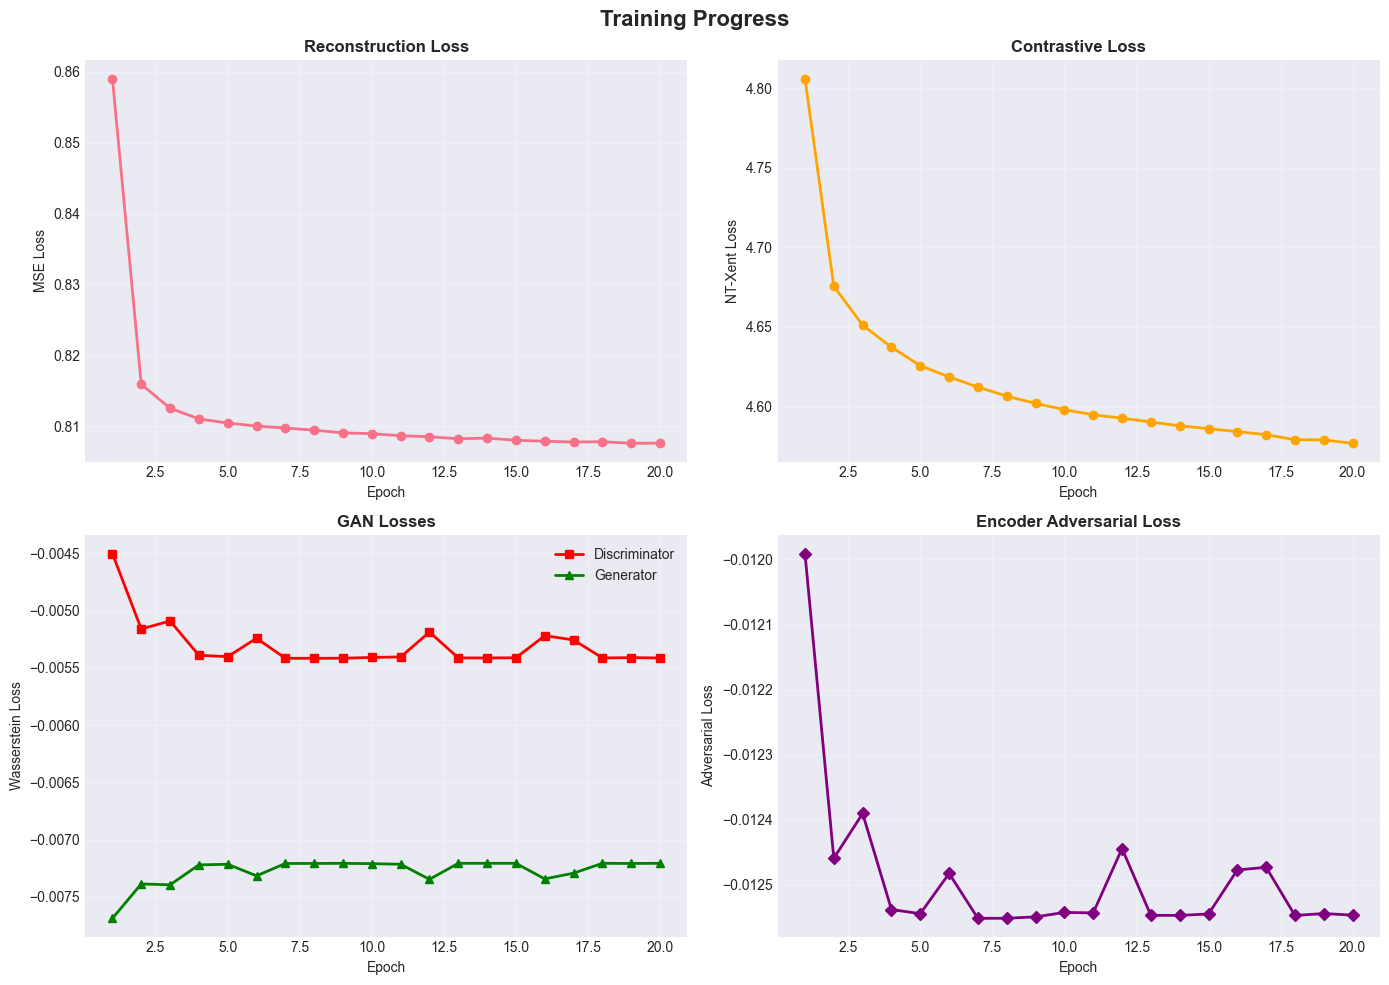

✓ Training curves plotted


In [31]:


# ============================================================================
# PLOT TRAINING CURVES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training Progress', fontsize=16, fontweight='bold')

# Reconstruction Loss
axes[0, 0].plot(history['epoch'], history['recon_loss'], linewidth=2, marker='o')
axes[0, 0].set_title('Reconstruction Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].grid(True, alpha=0.3)

# Contrastive Loss
axes[0, 1].plot(history['epoch'], history['contrast_loss'], linewidth=2, marker='o', color='orange')
axes[0, 1].set_title('Contrastive Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('NT-Xent Loss')
axes[0, 1].grid(True, alpha=0.3)

# GAN Losses
axes[1, 0].plot(history['epoch'], history['disc_loss'], linewidth=2, marker='s', label='Discriminator', color='red')
axes[1, 0].plot(history['epoch'], history['gen_loss'], linewidth=2, marker='^', label='Generator', color='green')
axes[1, 0].set_title('GAN Losses', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Wasserstein Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Encoder Adversarial Loss
axes[1, 1].plot(history['epoch'], history['enc_adv_loss'], linewidth=2, marker='D', color='purple')
axes[1, 1].set_title('Encoder Adversarial Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Adversarial Loss')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training curves plotted")


 ## 🎯 Section 10: Evaluation - Compute Anomaly Scores


In [32]:

# ============================================================================
# COMPUTE NORMAL DISTRIBUTION IN LATENT SPACE
# ============================================================================

print("Computing normal distribution in latent space...")
model.eval()

all_latents = []
with torch.no_grad():
    for batch in DataLoader(SequenceDataset(train_normal), batch_size=512):
        z = model.encode(batch.to(DEVICE))
        all_latents.append(z.cpu().numpy())

all_latents = np.concatenate(all_latents, axis=0)

# Compute statistics
z_mean = all_latents.mean(axis=0)
z_cov = np.cov(all_latents, rowvar=False) + 1e-6 * np.eye(all_latents.shape[1])
z_inv_cov = np.linalg.inv(z_cov)

print(f"✓ Computed normal distribution")
print(f"  Latent mean shape: {z_mean.shape}")
print(f"  Latent covariance shape: {z_cov.shape}")



Computing normal distribution in latent space...
✓ Computed normal distribution
  Latent mean shape: (64,)
  Latent covariance shape: (64, 64)


In [33]:

# ============================================================================
# COMPUTE ANOMALY SCORES ON TEST SET
# ============================================================================

print("\nComputing anomaly scores on test set...")

scores = []
labels_list = []

with torch.no_grad():
    for i in range(0, len(X_test), 512):
        batch_x = torch.tensor(X_test[i:i+512], dtype=torch.float32).to(DEVICE)
        batch_y = y_test[i:i+512]
        
        # Forward pass
        z, recon = model(batch_x)
        
        # Check for NaN
        if torch.isnan(recon).any() or torch.isnan(z).any():
            print(f"⚠️  Warning: NaN detected in batch {i}, skipping...")
            continue
        
        # Reconstruction error
        recon_err = ((recon - batch_x)**2).mean(dim=(1, 2)).cpu().numpy()
        
        # Mahalanobis distance in latent space
        z_np = z.cpu().numpy()
        diff = z_np - z_mean[None, :]
        mahal_dist = np.sum(diff.dot(z_inv_cov) * diff, axis=1)
        
        # Combined anomaly score
        anomaly_score = recon_err + 0.001 * mahal_dist
        
        scores.extend(anomaly_score.tolist())
        labels_list.extend(batch_y.tolist())

scores = np.array(scores)
labels_list = np.array(labels_list)

# Handle any remaining NaN values
if np.isnan(scores).any():
    print("⚠️  Warning: NaN values in scores, replacing with max score")
    scores = np.nan_to_num(scores, nan=np.nanmax(scores))

print(f"✓ Anomaly scores computed for {len(scores)} test samples")



Computing anomaly scores on test set...
✓ Anomaly scores computed for 56960 test samples


 ## 📊 Section 11: Performance Metrics

In [34]:


# ============================================================================
# COMPUTE EVALUATION METRICS
# ============================================================================

print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

# ROC-AUC
roc_auc = roc_auc_score(labels_list, scores)

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(labels_list, scores)
pr_auc = auc(recall, precision)

# ROC curve data
fpr, tpr, thresholds = roc_curve(labels_list, scores)

print(f"\n🎯 Performance:")
print(f"  ROC-AUC Score:  {roc_auc:.4f}")
print(f"  PR-AUC Score:   {pr_auc:.4f}")

# Find optimal threshold (Youden's J statistic)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\n📍 Optimal Threshold: {optimal_threshold:.6f}")
print(f"  (Maximizes TPR - FPR)")

# Classification at optimal threshold
predictions = (scores >= optimal_threshold).astype(int)

print(f"\n📋 Classification Report at Optimal Threshold:")
print(classification_report(labels_list, predictions, target_names=['Normal', 'Anomaly']))



EVALUATION METRICS

🎯 Performance:
  ROC-AUC Score:  0.8906
  PR-AUC Score:   0.1680

📍 Optimal Threshold: 0.988992
  (Maximizes TPR - FPR)

📋 Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

      Normal       1.00      0.83      0.90     56072
     Anomaly       0.07      0.86      0.13       888

    accuracy                           0.83     56960
   macro avg       0.53      0.84      0.52     56960
weighted avg       0.98      0.83      0.89     56960



 ## 📈 Section 12: Visualization of Results



 ### 12.1 ROC Curve


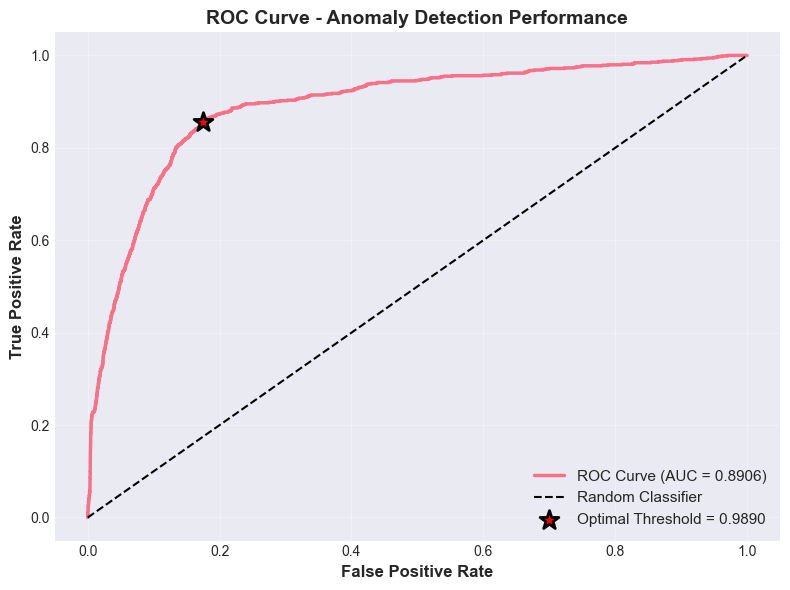

✓ ROC curve plotted


In [35]:

# ============================================================================
# PLOT ROC CURVE
# ============================================================================

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], s=200, c='red', marker='*', 
            edgecolors='black', linewidths=2, zorder=5,
            label=f'Optimal Threshold = {optimal_threshold:.4f}')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Anomaly Detection Performance', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curve plotted")



 ### 12.2 Precision-Recall Curve


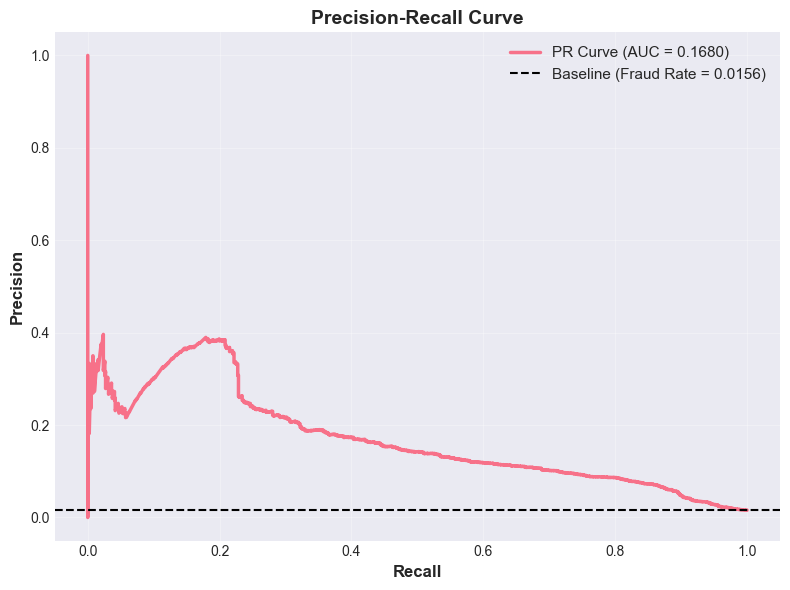

✓ Precision-Recall curve plotted


In [36]:

# ============================================================================
# PLOT PRECISION-RECALL CURVE
# ============================================================================

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2.5, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axhline(y=labels_list.mean(), color='k', linestyle='--', linewidth=1.5,
            label=f'Baseline (Fraud Rate = {labels_list.mean():.4f})')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Precision-Recall curve plotted")


 ### 12.3 Confusion Matrix


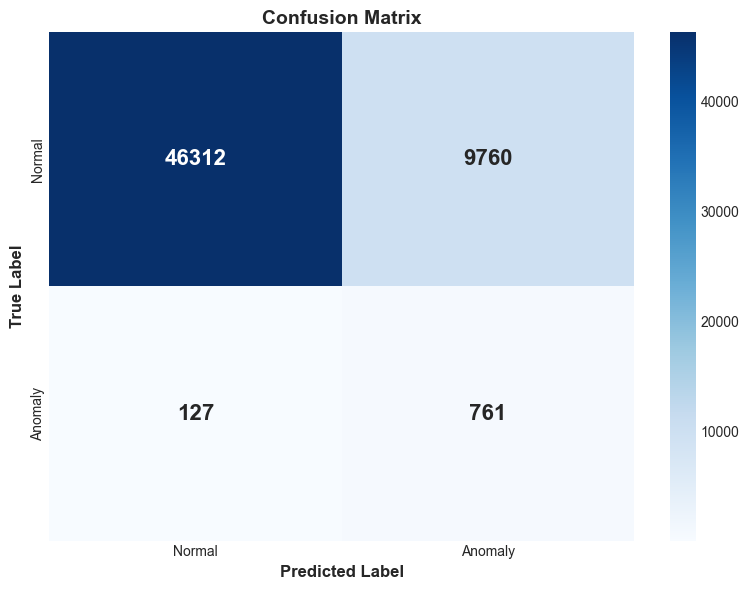


📊 Confusion Matrix Breakdown:
  True Negatives:   46312
  False Positives:   9760
  False Negatives:    127
  True Positives:     761

  Specificity: 0.8259
  Sensitivity: 0.8570


In [37]:

# ============================================================================
# PLOT CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(labels_list, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={'size': 16, 'weight': 'bold'})

plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix statistics
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"  True Negatives:  {tn:6d}")
print(f"  False Positives: {fp:6d}")
print(f"  False Negatives: {fn:6d}")
print(f"  True Positives:  {tp:6d}")
print(f"\n  Specificity: {tn/(tn+fp):.4f}")
print(f"  Sensitivity: {tp/(tp+fn):.4f}")


 ### 12.4 Anomaly Score Distribution


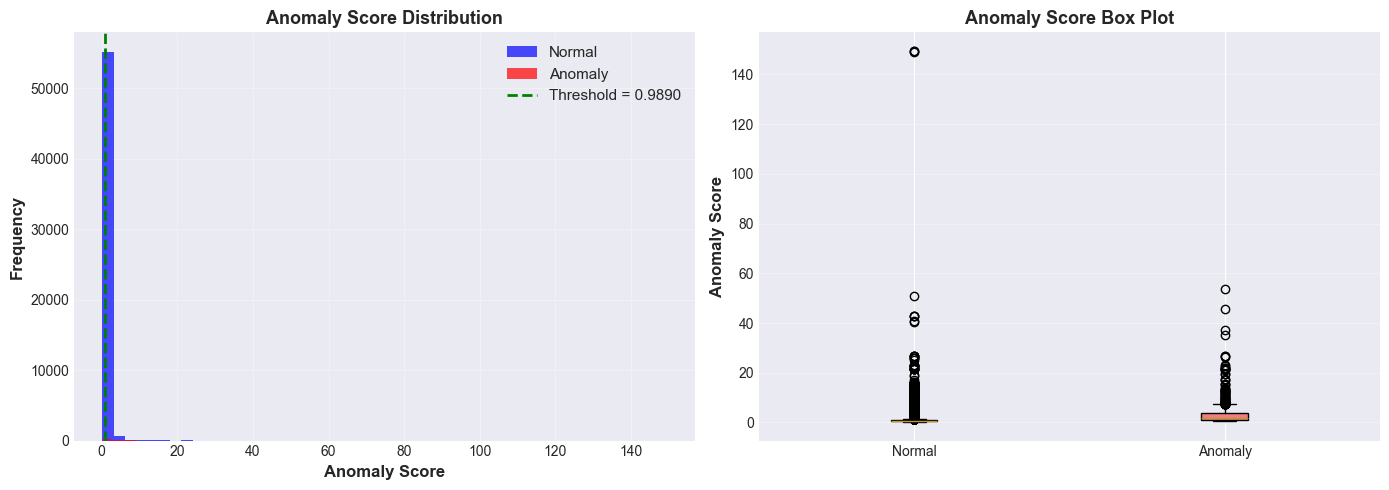

✓ Score distribution plots created

📈 Score Statistics:
  Normal samples:
    Mean: 0.869403
    Std:  1.504434
  Anomaly samples:
    Mean: 3.452719
    Std:  4.607594


In [38]:


# ============================================================================
# PLOT ANOMALY SCORE DISTRIBUTIONS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(scores[labels_list == 0], bins=50, alpha=0.7, label='Normal', color='blue')
axes[0].hist(scores[labels_list == 1], bins=50, alpha=0.7, label='Anomaly', color='red')
axes[0].axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, 
                label=f'Threshold = {optimal_threshold:.4f}')
axes[0].set_xlabel('Anomaly Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Anomaly Score Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [scores[labels_list == 0], scores[labels_list == 1]]
bp = axes[1].boxplot(data_to_plot, labels=['Normal', 'Anomaly'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Anomaly Score', fontsize=12, fontweight='bold')
axes[1].set_title('Anomaly Score Box Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Score distribution plots created")

# Print statistics
print(f"\n📈 Score Statistics:")
print(f"  Normal samples:")
print(f"    Mean: {scores[labels_list == 0].mean():.6f}")
print(f"    Std:  {scores[labels_list == 0].std():.6f}")
print(f"  Anomaly samples:")
print(f"    Mean: {scores[labels_list == 1].mean():.6f}")
print(f"    Std:  {scores[labels_list == 1].std():.6f}")



 ### 12.5 Sample Reconstructions




Visualizing sample reconstructions...


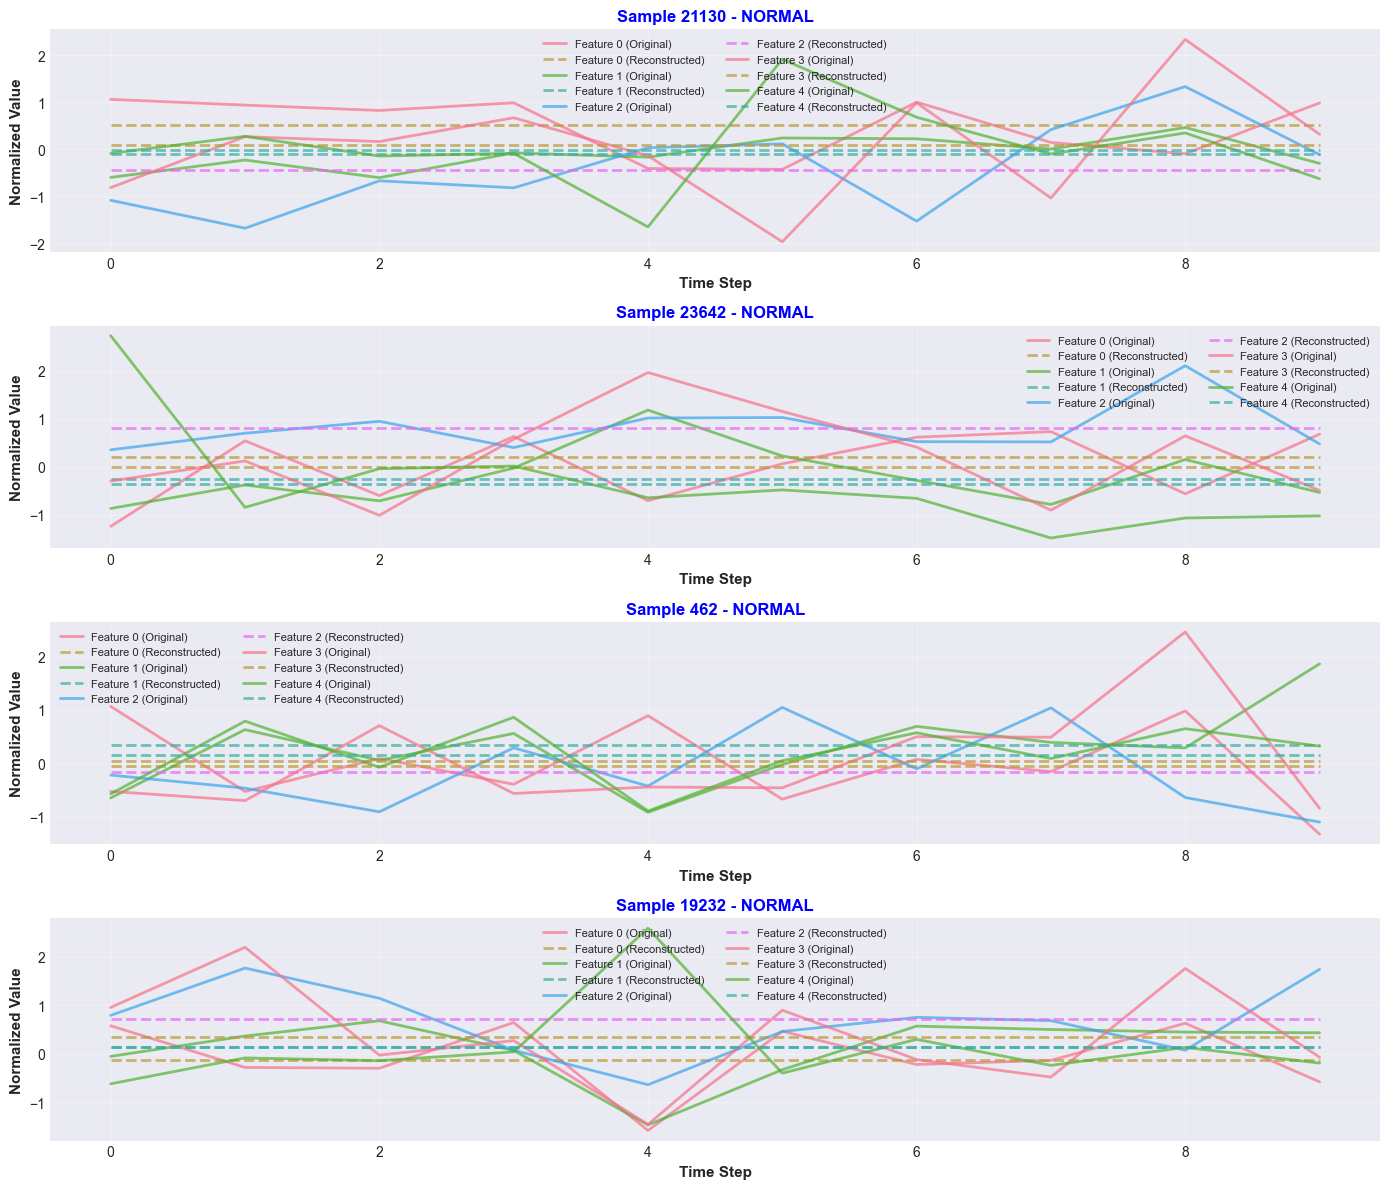

✓ Sample reconstructions visualized


In [39]:

# ============================================================================
# VISUALIZE SAMPLE RECONSTRUCTIONS
# ============================================================================

print("\nVisualizing sample reconstructions...")

# Get a few test samples
num_samples = 4
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3*num_samples))
if num_samples == 1:
    axes = [axes]

model.eval()
with torch.no_grad():
    for idx, ax in zip(sample_indices, axes):
        # Get sample
        sample = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(DEVICE)
        label = y_test[idx]
        
        # Reconstruct
        z, recon = model(sample)
        
        # Convert to numpy
        original = sample[0].cpu().numpy()
        reconstructed = recon[0].cpu().numpy()
        
        # Plot first 5 features over time
        time_steps = range(WINDOW_SIZE)
        for feat_idx in range(min(5, feat_dim)):
            ax.plot(time_steps, original[:, feat_idx], 
                   label=f'Feature {feat_idx} (Original)', 
                   linestyle='-', linewidth=2, alpha=0.7)
            ax.plot(time_steps, reconstructed[:, feat_idx], 
                   label=f'Feature {feat_idx} (Reconstructed)', 
                   linestyle='--', linewidth=2, alpha=0.7)
        
        ax.set_xlabel('Time Step', fontsize=11, fontweight='bold')
        ax.set_ylabel('Normalized Value', fontsize=11, fontweight='bold')
        ax.set_title(f'Sample {idx} - {"ANOMALY" if label == 1 else "NORMAL"}', 
                    fontsize=12, fontweight='bold',
                    color='red' if label == 1 else 'blue')
        ax.legend(loc='best', fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Sample reconstructions visualized")


 ## 💾 Section 13: Save Model and Artifacts



In [44]:

# ============================================================================
# SAVE MODEL CHECKPOINT
# ============================================================================

save_path = "./data/artifacts.pth"

checkpoint = {
    'model_state_dict': model.state_dict(),
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_ae_state_dict': optimizer_ae.state_dict(),
    'optimizer_gen_state_dict': optimizer_gen.state_dict(),
    'optimizer_disc_state_dict': optimizer_disc.state_dict(),
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'z_mean': z_mean,
    'z_inv_cov': z_inv_cov,
    'config': {
        'window_size': WINDOW_SIZE,
        'feat_dim': feat_dim,
        'd_model': D_MODEL,
        'nhead': NHEAD,
        'num_encoder_layers': NUM_ENCODER_LAYERS,
        'latent_dim': LATENT_DIM,
        'optimal_threshold': optimal_threshold
    },
    'metrics': {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    },
    'history': history
}

torch.save(checkpoint, save_path)
print(f"✓ Model and artifacts saved to: {save_path}")



✓ Model and artifacts saved to: ./data/artifacts.pth


In [45]:

# ============================================================================
# SAVE TRAINING HISTORY AS CSV
# ============================================================================

history_df = pd.DataFrame(history)
history_path = "./data/training_history.csv"
history_df.to_csv(history_path, index=False)
print(f"✓ Training history saved to: {history_path}")


✓ Training history saved to: ./data/training_history.csv


 ## 📝 Section 14: Summary and Conclusions



In [47]:

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"  Total sequences: {len(sequences):,}")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Anomaly ratio: {labels.mean():.4%}")

print(f"\n🏗️  Model Architecture:")
print(f"  Window size: {WINDOW_SIZE}")
print(f"  Features: {feat_dim}")
print(f"  Transformer d_model: {D_MODEL}")
print(f"  Attention heads: {NHEAD}")
print(f"  Encoder layers: {NUM_ENCODER_LAYERS}")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Total parameters: {count_parameters(model) + count_parameters(generator) + count_parameters(discriminator):,}")

print(f"\n🎯 Performance Metrics:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC:  {pr_auc:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.6f}")

print(f"\n⚙️  Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss weights: recon={W_RECON}, contrast={W_CONTRAST}, adv={W_ADV}")

print(f"\n💾 Saved Artifacts:")
print(f"  ✓ Model checkpoint: {save_path}")
print(f"  ✓ Training history: {history_path}")

print("\n" + "="*70)
print("EXPERIMENT COMPLETED SUCCESSFULLY")
print("="*70)



SUMMARY

📊 Dataset:
  Total sequences: 284,798
  Training samples: 227,838
  Test samples: 56,960
  Anomaly ratio: 1.5594%

🏗️  Model Architecture:
  Window size: 10
  Features: 29
  Transformer d_model: 64
  Attention heads: 4
  Encoder layers: 2
  Latent dimension: 64
  Total parameters: 124,382

🎯 Performance Metrics:
  ROC-AUC: 0.8906
  PR-AUC:  0.1680
  Optimal Threshold: 0.988992

⚙️  Training Configuration:
  Epochs: 20
  Batch size: 256
  Learning rate: 0.0005
  Loss weights: recon=1.0, contrast=0.3, adv=0.01

💾 Saved Artifacts:
  ✓ Model checkpoint: ./data/artifacts.pth
  ✓ Training history: ./data/training_history.csv

EXPERIMENT COMPLETED SUCCESSFULLY


 ## 🔍 Section 15: Model Loading (Optional)


In [43]:

# ============================================================================
# LOAD MODEL FROM CHECKPOINT (EXAMPLE)
# ============================================================================

def load_model_from_checkpoint(checkpoint_path, device='cpu'):
    """
    Load trained model from checkpoint.
    
    Args:
        checkpoint_path: Path to saved checkpoint
        device: Device to load model on
    
    Returns:
        model, generator, discriminator, scaler_params, config, metrics
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Recreate model
    config = checkpoint['config']
    model = TransformerAutoencoder(
        feat_dim=config['feat_dim'],
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_encoder_layers'],
        latent_dim=config['latent_dim']
    ).to(device)
    
    generator = build_generator(config['latent_dim']).to(device)
    discriminator = build_discriminator(config['latent_dim']).to(device)
    
    # Load state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    # Set to eval mode
    model.eval()
    generator.eval()
    discriminator.eval()
    
    scaler_params = {
        'mean': checkpoint['scaler_mean'],
        'scale': checkpoint['scaler_scale']
    }
    
    return model, generator, discriminator, scaler_params, config, checkpoint['metrics']

print("✓ Model loading function defined")
print("\nTo load the model later, use:")
print("  model, gen, disc, scaler_params, config, metrics = load_model_from_checkpoint(save_path)")


✓ Model loading function defined

To load the model later, use:
  model, gen, disc, scaler_params, config, metrics = load_model_from_checkpoint(save_path)
